# Examen Final de Recuperación de Información

**Nombre:** Galo Tarapués
**Docente:** Prof. Iván Carrera

In [1]:
# Importaciones base
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')


## Parte 1: Selección y Preprocesamiento del Corpus

In [2]:
# [CELDA 1] - Importaciones para procesamiento
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm.notebook import tqdm
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from joblib import Memory



In [3]:
# [CELDA 2] - Configuración inicial
memory = Memory(location='./cache', verbose=0)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [4]:
# [CELDA 3] - Carga del corpus
@memory.cache
def load_20newsgroups() -> Tuple[List[str], List[str], List[int]]:
    dataset = fetch_20newsgroups(
        subset='all',
        remove=('headers', 'footers', 'quotes'),
        shuffle=True,
        random_state=42
    )
    return dataset.data, dataset.target_names, dataset.target



In [5]:
# [CELDA 4] - Análisis inicial del corpus
def analyze_corpus(texts: List[str], categories: List[str], targets: List[int]) -> Dict:
    stats = {
        'total_documents': len(texts),
        'total_categories': len(categories),
        'avg_document_length': np.mean([len(text.split()) for text in texts]),
        'documents_per_category': pd.Series(targets).value_counts().to_dict()
    }
    return stats



In [6]:
# [CELDA 5] - Visualización 
def display_corpus_examples(texts: List[str], targets: List[int], categories: List[str]) -> pd.DataFrame:
    examples_data = []

    for cat_id in np.random.choice(len(categories), 3, replace=False):
        cat_texts = [t for i, t in enumerate(texts) if targets[i] == cat_id]
        if cat_texts:
            text = np.random.choice(cat_texts)
            examples_data.append({
                'Categoría': categories[cat_id],
                'Muestra': text[:300] + '...',
                'Longitud': len(text),
                'Palabras': len(text.split())
            })

    return pd.DataFrame(examples_data)



In [7]:
# [CELDA 6] - Clase de preprocesamiento de texto
class TextPreprocessor:
    #Inicialización
    def __init__(self, min_word_length: int = 3, max_features: int = 50000):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.min_word_length = min_word_length
        self.max_features = max_features
        self.vectorizer = None
        self._compile_regex()

    #Compilación de expresiones regulares
    def _compile_regex(self):
        self.cleanup_regex = re.compile(r'[^a-zA-Z\s]')
        self.whitespace_regex = re.compile(r'\s+')

    #Limpieza de texto
    def clean_text(self, text: str) -> str:
        text = text.lower()
        text = self.cleanup_regex.sub(' ', text)
        text = self.whitespace_regex.sub(' ', text)
        return text.strip()

    #Procesamiento de un solo texto
    def process_single_text(self, text: str) -> str:
        text = self.clean_text(text)
        tokens = word_tokenize(text)

        processed_tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words
            and len(token) >= self.min_word_length
        ]

        return ' '.join(processed_tokens)
    #Procesamiento de un lote de textos
    def preprocess_batch(self, texts: List[str], batch_size: int = 1000) -> List[str]:
        processed_texts = []
        n_cores = mp.cpu_count()

        with ThreadPoolExecutor(max_workers=n_cores) as executor:
            for i in tqdm(range(0, len(texts), batch_size), desc="Procesando"):
                batch = texts[i:i + batch_size]
                results = list(executor.map(self.process_single_text, batch))
                processed_texts.extend(results)

        return processed_texts

    #Creación de la matriz TF-IDF
    def create_tfidf_matrix(self, texts: List[str]) -> np.ndarray:
        if self.vectorizer is None:
            self.vectorizer = TfidfVectorizer(
                max_features=self.max_features,
                ngram_range=(1, 2),
                use_idf=True,
                sublinear_tf=True,
                min_df=5,
                max_df=0.95
            )
            return self.vectorizer.fit_transform(texts)
        return self.vectorizer.transform(texts)



In [8]:
# [CELDA 7] - Clase para métricas y visualización
class CorpusAnalyzer:
    
    #Inicialización
    def __init__(self, texts: List[str], categories: List[str], targets: List[int]):
        self.texts = texts
        self.categories = categories
        self.targets = targets

    #Estadísticas básicas
    def get_basic_stats(self) -> pd.DataFrame:
        stats = []
        for cat_id, category in enumerate(self.categories):
            cat_texts = [t for i, t in enumerate(self.texts) if self.targets[i] == cat_id]
            stats.append({
                'Categoría': category,
                'Documentos': len(cat_texts),
                'Promedio palabras': np.mean([len(t.split()) for t in cat_texts]),
                'Longitud máxima': max([len(t) for t in cat_texts]),
                'Longitud mínima': min([len(t) for t in cat_texts])
            })
        return pd.DataFrame(stats)

    #Estadísticas de vocabulario
    def get_vocabulary_stats(self, processed_texts: List[str]) -> Dict:
        all_words = ' '.join(processed_texts).split()
        unique_words = set(all_words)
        return {
            'Total palabras': len(all_words),
            'Vocabulario único': len(unique_words),
            'Promedio palabras por documento': len(all_words) / len(processed_texts)
        }



In [9]:
# [CELDA 8] - Función principal de ejecución
def main():
    texts, categories, targets = load_20newsgroups()

    print("1. Análisis inicial del corpus:")
    stats = analyze_corpus(texts, categories, targets)
    for key, value in stats.items():
        print(f"{key}: {value}")

    print("\n2. Ejemplos de documentos por categoría:")
    examples_df = display_corpus_examples(texts, targets, categories)
    display(examples_df)

    # Preprocesamiento de textos
    preprocessor = TextPreprocessor()
    processed_texts = preprocessor.preprocess_batch(texts)

    # Análisis del corpus
    analyzer = CorpusAnalyzer(texts, categories, targets)

    print("\n3. Estadísticas por categoría:")
    stats_df = analyzer.get_basic_stats()
    display(stats_df)

    print("\n4. Estadísticas del vocabulario después del preprocesamiento:")
    vocab_stats = analyzer.get_vocabulary_stats(processed_texts)
    for key, value in vocab_stats.items():
        print(f"{key}: {value}")

    print("\n5. Generando matriz TF-IDF...")
    tfidf_matrix = preprocessor.create_tfidf_matrix(processed_texts)
    print(f"Dimensiones de la matriz TF-IDF: {tfidf_matrix.shape}")

    return processed_texts, tfidf_matrix, preprocessor



In [11]:
# [CELDA 9] - Ejecución
if __name__ == "__main__":
    import nltk
    nltk.download('wordnet')
    nltk.download('stopwords')
    
    texts, categories, targets = load_20newsgroups()
    processed_texts, tfidf_matrix, preprocessor = main()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\galot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Análisis inicial del corpus:
total_documents: 18846
total_categories: 20
avg_document_length: 181.6377480632495
documents_per_category: {10: 999, 15: 997, 8: 996, 9: 994, 11: 991, 7: 990, 13: 990, 5: 988, 14: 987, 2: 985, 12: 984, 3: 982, 6: 975, 1: 973, 4: 963, 17: 940, 16: 910, 0: 799, 18: 775, 19: 628}

2. Ejemplos de documentos por categoría:


,Categoría,Muestra,Longitud,Palabras
0,comp.windows.x,please subscrive me....,20,3
1,rec.motorcycles,\n1 hr/drink for the first 4 drinks.\n1.5 hour...,102,19
2,sci.electronics,"You can try SGS L6217A, it can achieve 256 cur...",203,33


Procesando:   0%|          | 0/19 [00:00<?, ?it/s]


3. Estadísticas por categoría:


,Categoría,Documentos,Promedio palabras,Longitud máxima,Longitud mínima
0,alt.atheism,799,196.886108,50957,0
1,comp.graphics,973,196.842754,61278,0
2,comp.os.ms-windows.misc,985,134.556345,158791,0
3,comp.sys.ibm.pc.hardware,982,125.578411,30172,0
4,comp.sys.mac.hardware,963,111.589823,51496,0
5,comp.windows.x,988,219.136640,65424,0
6,misc.forsale,975,107.903590,21810,0
7,rec.autos,990,113.132323,27257,0
8,rec.motorcycles,996,100.124498,35621,0
9,rec.sport.baseball,994,124.907445,15161,0



4. Estadísticas del vocabulario después del preprocesamiento:
Total palabras: 1764746
Vocabulario único: 86983
Promedio palabras por documento: 93.64034808447416

5. Generando matriz TF-IDF...
Dimensiones de la matriz TF-IDF: (18846, 49789)


## Parte 2: Indexación y Representación Vectorial

In [12]:
# [CELDA 1] - Importaciones específicas para indexación
import faiss
import numpy as np
from typing import Dict, List, Union, Tuple
import pandas as pd
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, vstack
import gc
from dataclasses import dataclass
import h5py
from pathlib import Path



In [13]:
# [CELDA 2] - Configuración y utilidades
@dataclass
class IndexConfig:
    n_lists: int = 100  # Número de clusters para IVF
    n_probes: int = 10  # Número de clusters a explorar durante la búsqueda
    dimension: int = 50000  # Dimensionalidad de los vectores
    batch_size: int = 1000  # Tamaño del batch para procesamiento

class VectorUtils:
    @staticmethod
    def sparse_to_dense(sparse_matrix: csr_matrix) -> np.ndarray:
        return sparse_matrix.toarray().astype('float32')

    @staticmethod
    def normalize_vectors(vectors: np.ndarray) -> np.ndarray:
        norms = np.linalg.norm(vectors, axis=1, keepdims=True)
        return np.divide(vectors, norms, where=norms != 0)



In [14]:
# [CELDA 3] - Clase base para representación vectorial
class VectorSpaceModel:
    
    #Inicialización
    def __init__(self, config: IndexConfig):
        self.config = config
        self.vector_matrix = None
        self.document_ids = None

    #Método para transformar una matriz TF-IDF a espacio vectorial denso
    def _process_batch(self, matrix: csr_matrix, start_idx: int, end_idx: int) -> np.ndarray:
        batch = matrix[start_idx:end_idx]
        dense_batch = VectorUtils.sparse_to_dense(batch)
        return VectorUtils.normalize_vectors(dense_batch)

    #Método para transformar una matriz TF-IDF a espacio vectorial denso
    def transform_tfidf_matrix(self, tfidf_matrix: csr_matrix) -> np.ndarray:
        print("Transformando matriz TF-IDF a espacio vectorial denso...")
        n_samples = tfidf_matrix.shape[0]
        result = []

        for i in tqdm(range(0, n_samples, self.config.batch_size)):
            end_idx = min(i + self.config.batch_size, n_samples)
            batch = self._process_batch(tfidf_matrix, i, end_idx)
            result.append(batch)

        final_matrix = np.vstack(result)
        del result
        gc.collect()

        return final_matrix



In [15]:
# [CELDA 4] - Implementación de índice FAISS
class FAISSIndex:
    def __init__(self, config: IndexConfig):
        self.config = config
        self.index = None
        self.is_trained = False

    def build_index(self, vectors: np.ndarray) -> faiss.Index:
        print("Construyendo índice FAISS...")
        dimension = vectors.shape[1]

        # Creamos un índice IVF con un quantizer plano
        quantizer = faiss.IndexFlatL2(dimension)
        self.index = faiss.IndexIVFFlat(
            quantizer, dimension, self.config.n_lists, faiss.METRIC_INNER_PRODUCT
        )

        if not self.is_trained:
            print("Entrenando índice...")
            self.index.train(vectors)
            self.is_trained = True

        print("Añadiendo vectores al índice...")
        self.index.add(vectors)
        self.index.nprobe = self.config.n_probes

        return self.index



In [16]:
# [CELDA 5] - Clase para persistencia de datos
class VectorStorage:
    def __init__(self, storage_path: str = './vector_storage.h5'):
        self.storage_path = Path(storage_path)

    #Método para guardar vectores y sus IDs
    def save_vectors(self, vectors: np.ndarray, document_ids: List[int]):
        print("Guardando vectores en almacenamiento persistente...")
        with h5py.File(self.storage_path, 'w') as f:
            f.create_dataset('vectors', data=vectors)
            f.create_dataset('document_ids', data=document_ids)

    #Método para cargar vectores y sus IDs
    def load_vectors(self) -> Tuple[np.ndarray, List[int]]:
        print("Cargando vectores desde almacenamiento...")
        with h5py.File(self.storage_path, 'r') as f:
            vectors = f['vectors'][:]
            document_ids = f['document_ids'][:].tolist()
        return vectors, document_ids



In [17]:
# [CELDA 6] - Clase principal para gestión de indexación
class IndexManager:
    def __init__(self, config: IndexConfig):
        self.config = config
        self.vector_model = VectorSpaceModel(config)
        self.faiss_index = FAISSIndex(config)
        self.storage = VectorStorage()
        self.vectors = None
        self.document_ids = None

    def build_complete_index(self, tfidf_matrix: csr_matrix, document_ids: List[int]) -> Dict:
        # Transformación a espacio vectorial
        self.vectors = self.vector_model.transform_tfidf_matrix(tfidf_matrix)
        self.document_ids = document_ids

        # Construcción del índice
        self.faiss_index.build_index(self.vectors)

        # Almacenamiento persistente
        self.storage.save_vectors(self.vectors, document_ids)

        return {
            'dimensiones_vectores': self.vectors.shape,
            'documentos_indexados': len(document_ids),
            'memoria_utilizada_mb': self.vectors.nbytes / 1024 / 1024
        }

    #Método para realizar una búsqueda
    def get_index_stats(self) -> pd.DataFrame:
        stats = {
            'Métrica': [
                'Dimensionalidad',
                'Documentos indexados',
                'Clusters (IVF)',
                'Clusters explorados',
                'Memoria vectores (MB)',
                'Batch size'
            ],
            'Valor': [
                self.vectors.shape[1],
                len(self.document_ids),
                self.config.n_lists,
                self.config.n_probes,
                self.vectors.nbytes / 1024 / 1024,
                self.config.batch_size
            ]
        }
        return pd.DataFrame(stats)



In [18]:
# [CELDA 7] - Función principal de ejecución
def main(tfidf_matrix: csr_matrix, document_ids: List[int]) -> Tuple[IndexManager, Dict]:
    # Configuración
    config = IndexConfig(
        dimension=tfidf_matrix.shape[1],
        n_lists=min(100, int(np.sqrt(tfidf_matrix.shape[0]))),
        batch_size=1000
    )

    # Inicialización y construcción del índice
    index_manager = IndexManager(config)
    index_stats = index_manager.build_complete_index(tfidf_matrix, document_ids)

    print("\nEstadísticas del índice:")
    display(index_manager.get_index_stats())

    return index_manager, index_stats



In [19]:
# [CELDA 8] - Ejemplo de uso
if __name__ == "__main__":
    # Ejecución de la función principal
    document_ids = list(range(tfidf_matrix.shape[0]))
    index_manager, stats = main(tfidf_matrix, document_ids)

Transformando matriz TF-IDF a espacio vectorial denso...


  0%|          | 0/19 [00:00<?, ?it/s]

Construyendo índice FAISS...
Entrenando índice...
Añadiendo vectores al índice...
Guardando vectores en almacenamiento persistente...

Estadísticas del índice:


,Métrica,Valor
0,Dimensionalidad,49789.000000
1,Documentos indexados,18846.000000
2,Clusters (IVF),100.000000
3,Clusters explorados,10.000000
4,Memoria vectores (MB),3579.420067
5,Batch size,1000.000000


## Parte 3: Aplicación de Técnicas de Recuperación de Información

In [20]:
pip install sentence-transformers gensim torch

Note: you may need to restart the kernel to use updated packages.


In [21]:
# [CELDA 1] - Importaciones necesarias
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Any
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import torch
from tqdm.notebook import tqdm
import gc
from dataclasses import dataclass
import logging
logging.basicConfig(level=logging.INFO)



In [22]:
# [CELDA 2] - Configuración y utilidades
@dataclass
#Configuración de búsqueda
class SearchConfig:
    top_k: int = 10 # Número de resultados a retornar
    batch_size: int = 32 # Tamaño del batch para procesamiento
    w2v_vector_size: int = 300 # Tamaño de los vectores Word2Vec
    w2v_window: int = 5 # Tamaño de la ventana de contexto
    w2v_min_count: int = 2 # Frecuencia mínima de palabras
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' # Dispositivo para cómputo

#Clase para utilidades de búsqueda
class SearchUtils:
    @staticmethod
    def normalize_query(query: str, preprocessor: Any) -> str:
        return preprocessor.process_single_text(query)

    @staticmethod
    def get_top_k_indices(similarities: np.ndarray, k: int) -> np.ndarray:
        return np.argsort(similarities)[-k:][::-1]



In [23]:
# [CELDA 3] - Clase base para búsqueda
class BaseSearchMethod:
    
    #Inicialización
    def __init__(self, config: SearchConfig):
        self.config = config
        self.is_initialized = False

    #Método de inicialización
    def initialize(self, *args, **kwargs):
        raise NotImplementedError

    #Método de búsqueda
    def search(self, query: str, *args, **kwargs) -> List[Tuple[int, float]]:
        raise NotImplementedError



In [24]:
# [CELDA 4] - Implementación de búsqueda TF-IDF
class TFIDFSearch(BaseSearchMethod):
    
    #Inicialización
    def __init__(self, config: SearchConfig):
        super().__init__(config)
        self.preprocessor = None
        self.vectorizer = None
        self.tfidf_matrix = None

    #Método de inicialización
    def initialize(self, preprocessor: Any, tfidf_matrix: csr_matrix):
        self.preprocessor = preprocessor
        self.vectorizer = preprocessor.vectorizer
        self.tfidf_matrix = tfidf_matrix
        self.is_initialized = True

    #Método de búsqueda
    def search(self, query: str) -> List[Tuple[int, float]]:
        if not self.is_initialized:
            raise ValueError("Método no inicializado")

        # Preprocesar y vectorizar la consulta
        processed_query = SearchUtils.normalize_query(query, self.preprocessor)
        query_vector = self.vectorizer.transform([processed_query])

        # Calcular similitudes por lotes
        similarities = []
        for i in range(0, self.tfidf_matrix.shape[0], self.config.batch_size):
            batch = self.tfidf_matrix[i:i + self.config.batch_size]
            batch_similarities = cosine_similarity(query_vector, batch)
            similarities.extend(batch_similarities[0])

        # Obtener los top-k resultados
        similarities = np.array(similarities)
        top_indices = SearchUtils.get_top_k_indices(similarities, self.config.top_k)

        return list(zip(top_indices, similarities[top_indices]))



In [25]:
# [CELDA 5] - Implementación de búsqueda Word2Vec
class Word2VecSearch(BaseSearchMethod):
    def __init__(self, config: SearchConfig):
        super().__init__(config)
        self.model = None
        self.document_vectors = None
        self.preprocessor = None

    def initialize(self, preprocessor: Any, processed_texts: List[str]):
        self.preprocessor = preprocessor

        # Preparar datos para entrenamiento
        tokenized_texts = [text.split() for text in processed_texts]

        # Entrenar modelo Word2Vec
        print("Entrenando modelo Word2Vec...")
        self.model = Word2Vec(
            sentences=tokenized_texts,
            vector_size=self.config.w2v_vector_size,
            window=self.config.w2v_window,
            min_count=self.config.w2v_min_count,
            workers=4
        )

        # Calcular vectores de documentos
        print("Calculando vectores de documentos...")
        self.document_vectors = np.zeros((len(processed_texts), self.config.w2v_vector_size))

        for idx, text in enumerate(tqdm(tokenized_texts)):
            word_vectors = [self.model.wv[word] for word in text if word in self.model.wv]
            if word_vectors:
                self.document_vectors[idx] = np.mean(word_vectors, axis=0)

        self.is_initialized = True

    #Método para obtener el vector de consulta
    def _get_query_vector(self, query: str) -> np.ndarray:
        processed_query = SearchUtils.normalize_query(query, self.preprocessor)
        query_words = processed_query.split()
        word_vectors = [self.model.wv[word] for word in query_words if word in self.model.wv]

        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(self.config.w2v_vector_size)

    def search(self, query: str) -> List[Tuple[int, float]]:
        if not self.is_initialized:
            raise ValueError("Método no inicializado")

        query_vector = self._get_query_vector(query)

        # Calcular similitudes por lotes
        similarities = []
        for i in range(0, len(self.document_vectors), self.config.batch_size):
            batch = self.document_vectors[i:i + self.config.batch_size]
            batch_similarities = cosine_similarity([query_vector], batch)
            similarities.extend(batch_similarities[0])

        similarities = np.array(similarities)
        top_indices = SearchUtils.get_top_k_indices(similarities, self.config.top_k)

        return list(zip(top_indices, similarities[top_indices]))



In [26]:
# [CELDA 6] - Implementación de búsqueda con Transformers
class TransformerSearch(BaseSearchMethod):
    def __init__(self, config: SearchConfig):
        super().__init__(config)
        self.model = None
        self.document_embeddings = None
        self.preprocessor = None

    def initialize(self, preprocessor: Any, texts: List[str]):
        self.preprocessor = preprocessor

        print("Cargando modelo de Sentence Transformers...")
        self.model = SentenceTransformer('all-MiniLM-L6-v2', device=self.config.device)

        print("Generando embeddings de documentos...")
        self.document_embeddings = []

        for i in tqdm(range(0, len(texts), self.config.batch_size)):
            batch_texts = texts[i:i + self.config.batch_size]
            batch_embeddings = self.model.encode(
                batch_texts,
                batch_size=self.config.batch_size,
                show_progress_bar=False,
                convert_to_tensor=True,
                device=self.config.device
            )
            self.document_embeddings.append(batch_embeddings.cpu().numpy())

        self.document_embeddings = np.vstack(self.document_embeddings)
        self.is_initialized = True

    def search(self, query: str) -> List[Tuple[int, float]]:
        if not self.is_initialized:
            raise ValueError("Método no inicializado")

        # Obtener embedding de la consulta
        query_embedding = self.model.encode(
            query,
            convert_to_tensor=True,
            device=self.config.device
        ).cpu().numpy()

        # Calcular similitudes por lotes
        similarities = []
        for i in range(0, len(self.document_embeddings), self.config.batch_size):
            batch = self.document_embeddings[i:i + self.config.batch_size]
            batch_similarities = cosine_similarity([query_embedding], batch)
            similarities.extend(batch_similarities[0])

        similarities = np.array(similarities)
        top_indices = SearchUtils.get_top_k_indices(similarities, self.config.top_k)

        return list(zip(top_indices, similarities[top_indices]))



In [27]:
# [CELDA 7] - Clase para gestión de resultados
class SearchResultManager:
    @staticmethod
    def format_results(
        results: List[Tuple[int, float]],
        texts: List[str],
        categories: List[str],
        targets: List[int]
    ) -> pd.DataFrame:
        formatted_results = []
        for idx, score in results:
            formatted_results.append({
                'Índice': idx,
                'Categoría': categories[targets[idx]],
                'Puntuación': round(score, 4),
                'Texto': texts[idx][:200] + '...'
            })
        return pd.DataFrame(formatted_results)



In [28]:
# [CELDA 8] - Clase principal de búsqueda
class SearchManager:
    def __init__(self, config: SearchConfig):
        self.config = config
        self.tfidf_search = TFIDFSearch(config)
        self.w2v_search = Word2VecSearch(config)
        self.transformer_search = TransformerSearch(config)
        self.result_manager = SearchResultManager()

    def initialize_all(
        self,
        preprocessor: Any,
        tfidf_matrix: csr_matrix,
        processed_texts: List[str],
        original_texts: List[str]
    ):
        print("Inicializando métodos de búsqueda...")

        print("\n1. Inicializando búsqueda TF-IDF...")
        self.tfidf_search.initialize(preprocessor, tfidf_matrix)

        print("\n2. Inicializando búsqueda Word2Vec...")
        self.w2v_search.initialize(preprocessor, processed_texts)

        print("\n3. Inicializando búsqueda con Transformers...")
        self.transformer_search.initialize(preprocessor, original_texts)

    def search_all(
        self,
        query: str,
        texts: List[str],
        categories: List[str],
        targets: List[int]
    ) -> Dict[str, pd.DataFrame]:
        results = {}

        print("\nBuscando con TF-IDF...")
        tfidf_results = self.tfidf_search.search(query)
        results['TF-IDF'] = self.result_manager.format_results(
            tfidf_results, texts, categories, targets
        )

        print("Buscando con Word2Vec...")
        w2v_results = self.w2v_search.search(query)
        results['Word2Vec'] = self.result_manager.format_results(
            w2v_results, texts, categories, targets
        )

        print("Buscando con Transformers...")
        transformer_results = self.transformer_search.search(query)
        results['Transformer'] = self.result_manager.format_results(
            transformer_results, texts, categories, targets
        )

        return results



In [29]:
# [CELDA 9] - Función principal de ejecución
def main(
    tfidf_matrix: csr_matrix,
    preprocessor: Any,
    processed_texts: List[str],
    texts: List[str],
    categories: List[str],
    targets: List[int]
) -> SearchManager:
    config = SearchConfig()
    search_manager = SearchManager(config)

    search_manager.initialize_all(
        preprocessor=preprocessor,
        tfidf_matrix=tfidf_matrix,
        processed_texts=processed_texts,
        original_texts=texts
    )

    return search_manager



In [ ]:
# [CELDA 10] - Ejemplo de uso y prueba del sistema

from sklearn.datasets import fetch_20newsgroups

def load_test_data():
    # Cargar el dataset completo
    dataset = fetch_20newsgroups(
        subset='all',
        remove=('headers', 'footers', 'quotes'),
        shuffle=True,
        random_state=42 
    )

    # Obtener los datos necesarios
    texts = dataset.data
    categories = dataset.target_names
    targets = dataset.target

    print(f"Datos cargados: {len(texts)} documentos en {len(categories)} categorías")
    return texts, categories, targets

if __name__ == "__main__":
    # Cargar datos necesarios
    texts, categories, targets = load_test_data()

    # Inicializar el sistema de búsqueda
    search_manager = main(
        tfidf_matrix,
        preprocessor,
        processed_texts,
        texts,
        categories,
        targets
    )

    # Ejemplo de búsqueda
    print("\nRealizando búsqueda de prueba...")
    query = "computer science research"
    results = search_manager.search_all(query, texts, categories, targets)

    print("\nResultados de búsqueda:")
    for method, df in results.items():
        print(f"\nMétodo: {method}")
        display(df)

Datos cargados: 18846 documentos en 20 categorías
Inicializando métodos de búsqueda...

1. Inicializando búsqueda TF-IDF...

2. Inicializando búsqueda Word2Vec...


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Entrenando modelo Word2Vec...


INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 951778 words, keeping 61284 word types
INFO:gensim.models.word2vec:collected 86983 word types from a corpus of 1764746 raw words and 18846 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 44966 unique words (51.70% of original 86983, drops 42017)', 'datetime': '2025-02-23T01:42:00.437324', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 1722729 word corpus (97.62% of original 1764746, drops 42017)', 'datetime': '2025-02-23T01:42:00.437324', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_voc

Calculando vectores de documentos...


  0%|          | 0/18846 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2



3. Inicializando búsqueda con Transformers...
Cargando modelo de Sentence Transformers...
Generando embeddings de documentos...


  0%|          | 0/589 [00:00<?, ?it/s]


Realizando búsqueda de prueba...

Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Resultados de búsqueda:

Método: TF-IDF


,Índice,Categoría,Puntuación,Texto
0,12488,comp.graphics,0.2942,EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...
1,10854,comp.graphics,0.2817,"Hi,\n\nI'm hoping someone out there will be ab..."
2,17670,rec.autos,0.2757,Does anyone have a listing of Pontiac's three-...
3,16485,rec.autos,0.2752,"\n\n""Through a single data point, you can draw..."
4,17689,comp.sys.ibm.pc.hardware,0.2642,I'm trying to get in touch with Mitsumi - anyo...
5,1891,alt.atheism,0.2635,\nScience is the process of modeling the real ...
6,15680,comp.graphics,0.2608,es:\n\nxv 3.0 (shareware) supports 24-bit disp...
7,10506,comp.windows.x,0.2377,: What has this got to do with comp.windows.x?...
8,12148,comp.graphics,0.2306,"Hi folks,\n\nI'm doing an animated film on new..."
9,10048,rec.autos,0.2274,Is there anyone out there in NetLand that has/...



Método: Word2Vec


,Índice,Categoría,Puntuación,Texto
0,16151,comp.graphics,0.8956,JOB OPPORTUNITY\n\t\t ---------------\n\n...
1,8050,comp.graphics,0.8714,Technion - Israel Institute of Technology\n ...
2,12488,comp.graphics,0.8673,EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...
3,5488,sci.space,0.8649,\nGulp.\n\n[Disclaimer: This opinion is mine ...
4,3433,sci.space,0.8573,TRry the SKywatch project in Arizona....
5,5195,sci.med,0.8395,Resinfo (research and information) is currentl...
6,13799,comp.graphics,0.8239,"SAMPE, NCGA, The University of Akron, and NASA..."
7,12310,sci.electronics,0.8237,Hi Netters!\n\nI am looking for the list of un...
8,14218,sci.space,0.8235,"\nThe SEI. Software Engineering Institute, a D..."
9,13467,misc.forsale,0.8233,Texas Instruments TI-81 calculalor. Excellent ...



Método: Transformer


,Índice,Categoría,Puntuación,Texto
0,12488,comp.graphics,0.5012,EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...
1,11156,comp.sys.mac.hardware,0.4913,"\n Interesting, as I think computer tec..."
2,14218,sci.space,0.4642,"\nThe SEI. Software Engineering Institute, a D..."
3,14290,comp.graphics,0.4594,The Harvard Computer Society is pleased to ann...
4,8050,comp.graphics,0.4574,Technion - Israel Institute of Technology\n ...
5,3374,misc.forsale,0.4555,Hi!\n\nI have several computer related books f...
6,11407,comp.windows.x,0.4526,"\nAt Robert Gordon University, programming was..."
7,5635,comp.sys.mac.hardware,0.4367,"\nA professor of mine once said ""The differenc..."
8,17013,comp.graphics,0.4329,From article <1993May1.092058.1@aurora.alaska....
9,17645,comp.os.ms-windows.misc,0.4186,"Hey Larry,\n How can you be a comp sci ..."


## Parte 4: Evaluación mediante Benchmarking

In [55]:
# [CELDA 1] - Importaciones necesarias
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Any, Set
from dataclasses import dataclass
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')



In [56]:
# [CELDA 2] - Definición de consultas y ground truth
@dataclass
class QueryData:
    query: str
    relevant_categories: List[str]
    description: str

BENCHMARK_QUERIES = [
    QueryData(
        query="machine learning algorithms and applications",
        relevant_categories=["comp.ai", "sci.electronics"],
        description="Búsqueda sobre algoritmos de aprendizaje automático"
    ),
    QueryData(
        query="space exploration and NASA missions",
        relevant_categories=["sci.space"],
        description="Información sobre exploración espacial"
    ),
    QueryData(
        query="religious discussions and beliefs",
        relevant_categories=["soc.religion.christian", "alt.atheism"],
        description="Debates sobre religión"
    ),
    QueryData(
        query="computer graphics and image processing",
        relevant_categories=["comp.graphics"],
        description="Procesamiento de imágenes y gráficos"
    ),
    QueryData(
        query="political debates and discussions",
        relevant_categories=["talk.politics.misc", "talk.politics.guns"],
        description="Discusiones políticas"
    ),
    QueryData(
        query="operating systems and software",
        relevant_categories=["comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware"],
        description="Sistemas operativos y software"
    ),
    QueryData(
        query="medical research and health",
        relevant_categories=["sci.med"],
        description="Investigación médica y salud"
    ),
    QueryData(
        query="automotive technology and cars",
        relevant_categories=["rec.autos"],
        description="Tecnología automotriz"
    ),
    QueryData(
        query="sports events and competitions",
        relevant_categories=["rec.sport.baseball", "rec.sport.hockey"],
        description="Eventos deportivos"
    ),
    QueryData(
        query="encryption and computer security",
        relevant_categories=["sci.crypt"],
        description="Seguridad informática y encriptación"
    )
]



In [57]:
# prompt: ahora me sale este worgning :
# Warning: Category 'comp.ai' not found in ground truth data. Check your category names in BENCHMARK_QUERIES and dataset.

# [CELDA 3] - Clase para gestión del ground truth
class GroundTruthManager:
    def __init__(self, categories: List[str], targets: List[int]):
        self.categories = categories
        self.targets = targets
        self.category_to_indices = self._build_category_indices()

    def _build_category_indices(self) -> Dict[str, Set[int]]:
        category_indices = {}
        for i, target_index in enumerate(self.targets):
            try:
                category = self.categories[target_index]  # Use target_index to get category
                if category not in category_indices:
                    category_indices[category] = set()
                category_indices[category].add(i)  # Add document index to set
            except IndexError:
                print(f"Warning: Invalid target index {target_index} encountered. Skipping this document.")
        return category_indices

    def get_relevant_documents(self, query_data: QueryData) -> Set[int]:
        relevant_docs = set()
        for category in query_data.relevant_categories:
            # Handle the case where category might not be present
            if category in self.category_to_indices:
                relevant_docs.update(self.category_to_indices[category])
            else:
                print(f"Warning: Category '{category}' not found in ground truth data. Check your category names in BENCHMARK_QUERIES and dataset.")
        return relevant_docs


In [58]:
# [CELDA 4] - Clase para cálculo de métricas
class MetricsCalculator:
    @staticmethod
    def calculate_precision_recall(
        relevant_docs: Set[int],
        retrieved_docs: List[Tuple[int, float]],
        k: int = None
    ) -> Dict[str, float]:
        if k is None:
            k = len(retrieved_docs)

        retrieved_k = retrieved_docs[:k]
        retrieved_set = set([idx for idx, _ in retrieved_k])

        true_positives = len(relevant_docs.intersection(retrieved_set))

        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(relevant_docs) if relevant_docs else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    @staticmethod
    def calculate_mean_average_precision(
        relevant_docs: Set[int],
        retrieved_docs: List[Tuple[int, float]]
    ) -> float:
        if not relevant_docs:
            return 0.0

        precisions = []
        relevant_found = 0

        for i, (doc_id, _) in enumerate(retrieved_docs, 1):
            if doc_id in relevant_docs:
                relevant_found += 1
                precisions.append(relevant_found / i)

        return np.mean(precisions) if precisions else 0.0



In [59]:
# [CELDA 5] - Clase para evaluación
class BenchmarkEvaluator:
    def __init__(
        self,
        search_manager: Any,
        ground_truth_manager: GroundTruthManager,
        texts: List[str],
        categories: List[str],
        targets: List[int]
    ):
        self.search_manager = search_manager
        self.ground_truth_manager = ground_truth_manager
        self.texts = texts
        self.categories = categories
        self.targets = targets
        self.metrics_calculator = MetricsCalculator()
        self.results_cache = {}

    def evaluate_query(
        self,
        query_data: QueryData,
        k: int = 10
    ) -> Dict[str, Dict[str, float]]:
        query_key = f"{query_data.query}_{k}"
        if query_key in self.results_cache:
            return self.results_cache[query_key]

        # Obtener documentos relevantes del ground truth
        relevant_docs = self.ground_truth_manager.get_relevant_documents(query_data)

        # Realizar búsqueda con todos los métodos
        search_results = self.search_manager.search_all(
            query_data.query,
            self.texts,
            self.categories,
            self.targets
        )

        # Calcular métricas para cada método
        evaluation_results = {}
        for method, results_df in search_results.items():
            retrieved_docs = list(zip(results_df['Índice'], results_df['Puntuación']))

            # Calcular métricas básicas
            metrics = self.metrics_calculator.calculate_precision_recall(
                relevant_docs,
                retrieved_docs,
                k
            )

            # Calcular MAP
            map_score = self.metrics_calculator.calculate_mean_average_precision(
                relevant_docs,
                retrieved_docs
            )

            metrics['map'] = map_score
            evaluation_results[method] = metrics

        self.results_cache[query_key] = evaluation_results
        return evaluation_results



In [60]:
# [CELDA 6] - Clase para visualización de resultados
class BenchmarkVisualizer:
    @staticmethod
    def create_metrics_table(all_results: Dict[str, Dict[str, Dict[str, float]]]) -> pd.DataFrame:
        data = []
        for query, method_results in all_results.items():
            for method, metrics in method_results.items():
                row = {
                    'Query': query,
                    'Método': method,
                    'Precisión': metrics['precision'],
                    'Recall': metrics['recall'],
                    'F1': metrics['f1'],
                    'MAP': metrics['map']
                }
                data.append(row)
        return pd.DataFrame(data)

    @staticmethod
    def plot_metrics_comparison(df: pd.DataFrame):
        plt.figure(figsize=(15, 6))

        # Crear subplots para cada métrica
        metrics = ['Precisión', 'Recall', 'F1', 'MAP']
        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, 4, i)
            sns.boxplot(data=df, x='Método', y=metric)
            plt.title(f'Distribución de {metric}')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def generate_summary_report(df: pd.DataFrame) -> pd.DataFrame:
        return df.groupby('Método').agg({
            'Precisión': ['mean', 'std'],
            'Recall': ['mean', 'std'],
            'F1': ['mean', 'std'],
            'MAP': ['mean', 'std']
        }).round(4)



In [61]:
# [CELDA 7] - Clase principal para gestión de benchmark
class BenchmarkManager:
    def __init__(
        self,
        search_manager: Any,
        texts: List[str],
        categories: List[str],
        targets: List[int]
    ):
        self.ground_truth_manager = GroundTruthManager(categories, targets)
        self.evaluator = BenchmarkEvaluator(
            search_manager,
            self.ground_truth_manager,
            texts,
            categories,
            targets
        )
        self.visualizer = BenchmarkVisualizer()

    def run_benchmark(self, queries: List[QueryData] = BENCHMARK_QUERIES) -> Dict:
        print("Ejecutando benchmark...")
        all_results = {}

        for query_data in tqdm(queries, desc="Evaluando consultas"):
            results = self.evaluator.evaluate_query(query_data)
            all_results[query_data.description] = results

        return all_results

    def analyze_results(self, results: Dict) -> None:
        print("\nGenerando análisis de resultados...")

        # Crear tabla de métricas
        metrics_df = self.visualizer.create_metrics_table(results)

        # Mostrar resumen estadístico
        print("\nResumen estadístico por método:")
        summary_df = self.visualizer.generate_summary_report(metrics_df)
        display(summary_df)

        # Mostrar visualización
        print("\nVisualización de distribución de métricas:")
        self.visualizer.plot_metrics_comparison(metrics_df)

        return metrics_df



In [62]:
# [CELDA 8] - Función principal de ejecución
def main(
    search_manager: Any,
    texts: List[str],
    categories: List[str],
    targets: List[int]
) -> Tuple[BenchmarkManager, pd.DataFrame]:
    # Inicializar benchmark manager
    benchmark_manager = BenchmarkManager(
        search_manager,
        texts,
        categories,
        targets
    )

    # Ejecutar benchmark
    results = benchmark_manager.run_benchmark()

    # Analizar y visualizar resultados
    metrics_df = benchmark_manager.analyze_results(results)

    return benchmark_manager, metrics_df


Ejecutando benchmark...


Evaluando consultas:   0%|          | 0/10 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Buscando con TF-IDF...
Buscando con Word2Vec...
Buscando con Transformers...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Generando análisis de resultados...

Resumen estadístico por método:


Precisión          Recall              F1             MAP        
                 mean     std    mean     std    mean     std    mean     std
Método                                                                       
TF-IDF           0.52  0.3155  0.0047  0.0036  0.0093  0.0072  0.7848  0.2314
Transformer      0.72  0.3155  0.0061  0.0037  0.0120  0.0073  0.7481  0.3252
Word2Vec         0.52  0.3736  0.0045  0.0039  0.0089  0.0078  0.5419  0.3722


Visualización de distribución de métricas:


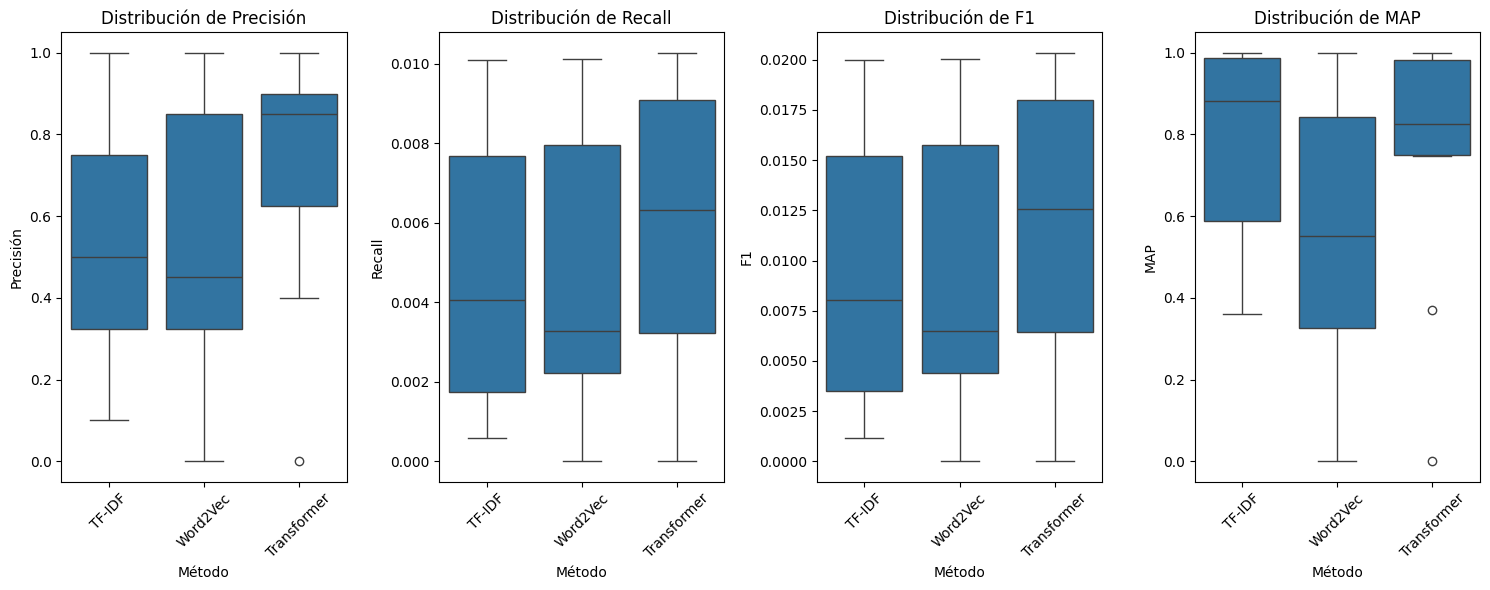

In [63]:

# [CELDA 9] - Ejemplo de uso
if __name__ == "__main__":
    
    benchmark_manager, metrics_df = main(
        search_manager,
        texts,
        categories,
        targets
    )